<a href="https://colab.research.google.com/github/aralbright/2021_AAMSME/blob/main/notebooks/Differential_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential expression

Input: adata_corrected.h5ad

Result: Volcano Plots, Upset Plot, Single Gene Plots, Mean DE Expression

In [3]:
!pip install anndata
!pip install diffxpy

In [4]:
# Import packages and setup 

import anndata
from anndata import AnnData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import diffxpy.api as de
from statsmodels.sandbox.stats.multicomp import multipletests

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load adata

In [5]:
!gdown --id 1_-N_u2_uUy_K5C_vqBp0o2WtalzlyLo_ -O adata_corrected.h5ad

Downloading...
From: https://drive.google.com/uc?id=1_-N_u2_uUy_K5C_vqBp0o2WtalzlyLo_
To: /content/adata_corrected.h5ad
1.23GB [00:10, 120MB/s]


In [6]:
# Load AnnData
adata = anndata.read_h5ad("adata_corrected.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 8400 × 6000
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [8]:
# remove mitochondrial and ribosomal genes
riboS = adata.var["gene"].str.startswith('RpS')
riboS = riboS.astype(bool)

riboL = adata.var["gene"].str.startswith('RpL')
riboL = riboL.astype(bool)

mriboS = adata.var["gene"].str.startswith('mRpS')
mriboS = mriboS.astype(bool)

mriboL = adata.var["gene"].str.startswith('mRpL')
mriboL = mriboL.astype(bool)

mito_genes = adata.var["gene"].str.startswith('mt:')
mito_genes = mito_genes.astype(bool)

badgenes = (riboS | riboL | mito_genes | riboS | riboL)

adata = adata[:, ~badgenes]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 8400 × 5910
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

## Differential expression within each cluster

In [10]:
adata.X = adata.layers['X_scvi_raw']

In [11]:
adata.obs.leiden_scVI.unique()

['2', '0', '5', '9', '3', '6', '1', '4', '8', '7']
Categories (10, object): ['2', '0', '5', '9', ..., '1', '4', '8', '7']

In [12]:
clusters = sorted(adata.obs.leiden_scVI.unique())
subs = {}
tests = {}
dfs = {}
sig_dfs = {}
corr_dfs = {}

# subset adata according to cluster 
for i in clusters: 
    
    # subset adata 
    
    name = i
    subs[name] = subs.get(name, adata[adata.obs['leiden_scVI'] == i])
    
subs['bulk'] = adata
    
# for each subset adata, run t-test between control and ctcf    
for sub in subs:     
    
    # run t-test between batches 
    
    ttest = 'test_tt_{}'.format(sub)
    tests[ttest] = de.test.t_test(data = subs[sub], grouping = 'batch')
    
# for each t-test, get the summary dataframe
for test in tests: 
    
    # get summary df 
    df = 'df_{}'.format(test)
    dfs[df] = tests[test].summary()
    
    # add cluster number to a column
    dfs[df]['cluster'] = df[-1]
    
# for each dataframe, bonferroni correct the p-value and filter for significance
for df in dfs: 
    
    # adjust p value 
    
    adj = multipletests(dfs[df]['pval'], alpha = 0.05, method='bonferroni')
    dfs[df]['padj'] = adj[1]
        
    # is significant? 

    dfs[df]['is_sig'] = ((dfs[df]['padj'] <= 0.05) & (abs(dfs[df]['log2fc']) >= 1.5))
       
    # filter for significance     
    
    sig_dfs[df] = dfs[df].loc[dfs[df]['is_sig'] == True]

    
for sig in sig_dfs: 
    
    # add cluster number as column 
    #sig_dfs[sig]['cluster'] = sig[-1]
    
    # correct the p-value for the number of upset comparisons
    sig_dfs[sig]['pcorr'] = (sig_dfs[sig]['padj'] * (len(clusters) + 1))
    
    # filter for significance into a final dictionary of genes to plot
    corr_dfs[sig] = sig_dfs[sig][(sig_dfs[sig]['pcorr'] <= 0.05)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [13]:
# merge all dfs in corr_dfs into one df 

frames = corr_dfs.values()

In [14]:
df_to_plot = pd.concat(frames)

In [15]:
dfs

{'df_test_tt_0':                      gene           pval  ...           padj  is_sig
 0         Su(Ste):CR42418   3.780738e-69  ...   2.234416e-65    True
 1                 CG40635   2.613213e-07  ...   1.544409e-03   False
 2          lncRNA:CR40719   3.320778e-02  ...   1.000000e+00   False
 3                    Adhr   3.663610e-17  ...   2.165194e-13   False
 4                 CG11929   1.370963e-57  ...   8.102391e-54    True
 ...                   ...            ...  ...            ...     ...
 5905              CR41506   5.034787e-24  ...   2.975559e-20   False
 5906  28SrRNA-Psi:CR40596   3.070785e-64  ...   1.814834e-60   False
 5907      28SrRNA:CR45837   2.148435e-87  ...   1.269725e-83   False
 5908     pre-rRNA:CR45846  1.229648e-122  ...  7.267219e-119    True
 5909      28SrRNA:CR45844   1.582186e-70  ...   9.350719e-67   False
 
 [5910 rows x 10 columns],
 'df_test_tt_1':                      gene           pval  ...           padj  is_sig
 0         Su(Ste):CR42418   

## Volcano Plot

In [16]:
for df in dfs: 
    
    dfs[df]['volcano_y'] = -np.log10(dfs[df]['padj'])
    

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
locals().update(dfs)

In [18]:
dfs.keys()

dict_keys(['df_test_tt_0', 'df_test_tt_1', 'df_test_tt_2', 'df_test_tt_3', 'df_test_tt_4', 'df_test_tt_5', 'df_test_tt_6', 'df_test_tt_7', 'df_test_tt_8', 'df_test_tt_9', 'df_test_tt_bulk'])

Cluster 0

In [19]:
xs = df_test_tt_0['log2fc']
ys = df_test_tt_0['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

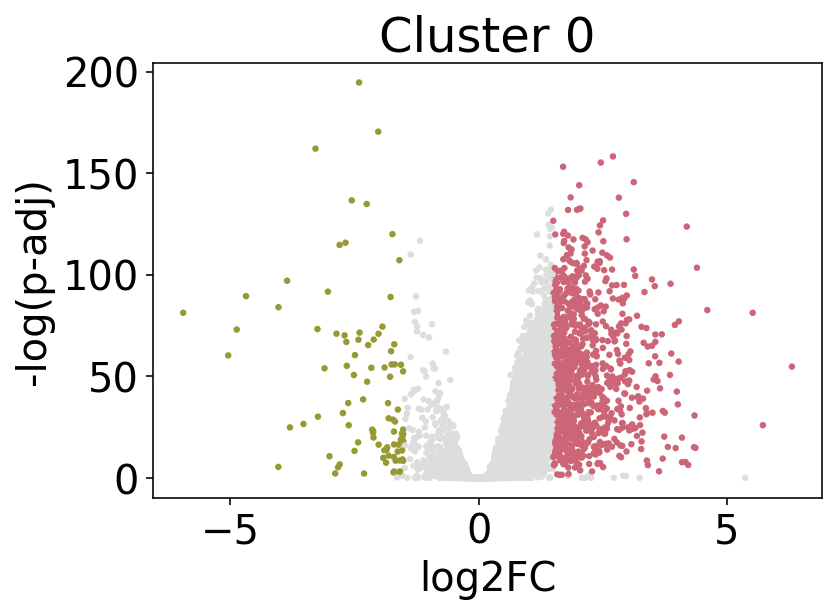

In [20]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 0')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster0.png', dpi = 400)

Cluster 1

In [21]:
xs = df_test_tt_1['log2fc']
ys = df_test_tt_1['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

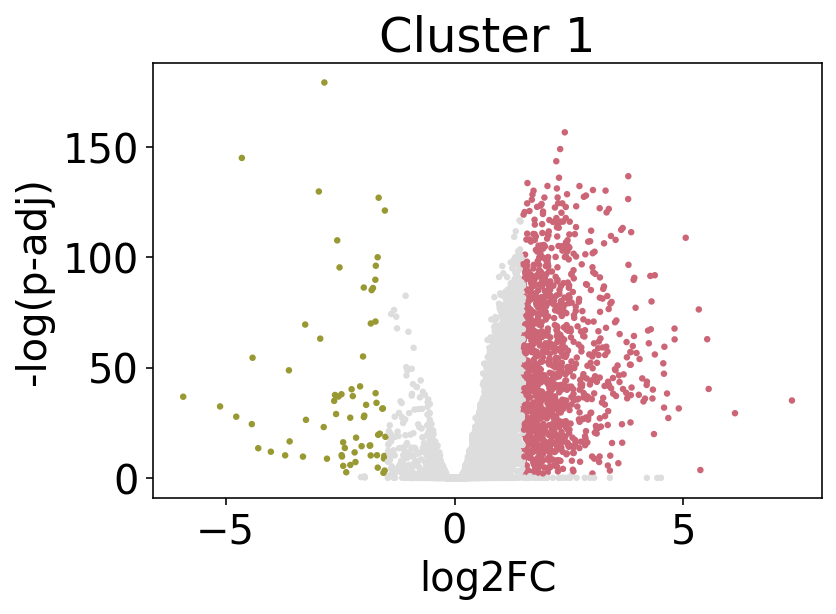

In [22]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 1')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster1.png', dpi = 400)

Cluster 2

In [23]:
xs = df_test_tt_2['log2fc']
ys = df_test_tt_2['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

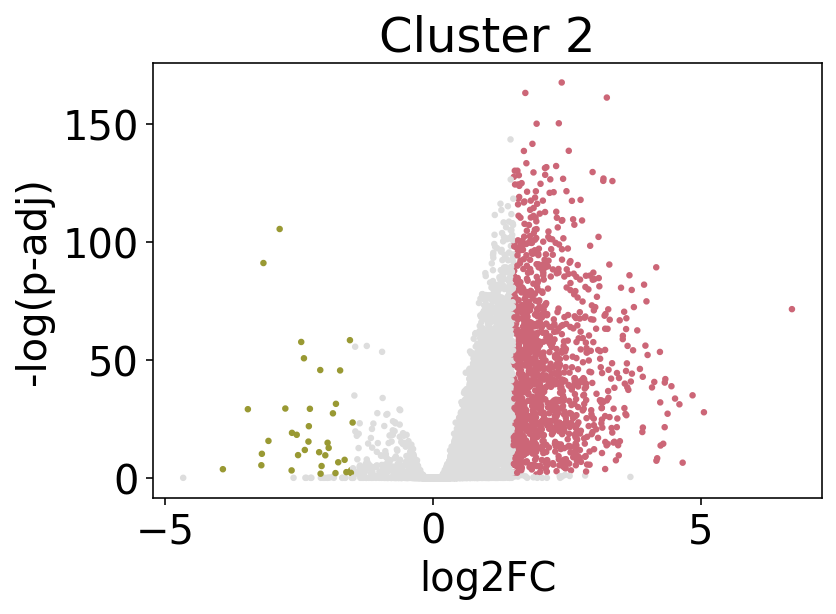

In [24]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 2')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster2.png', dpi = 400)

Cluster 3

In [25]:
xs = df_test_tt_3['log2fc']
ys = df_test_tt_3['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

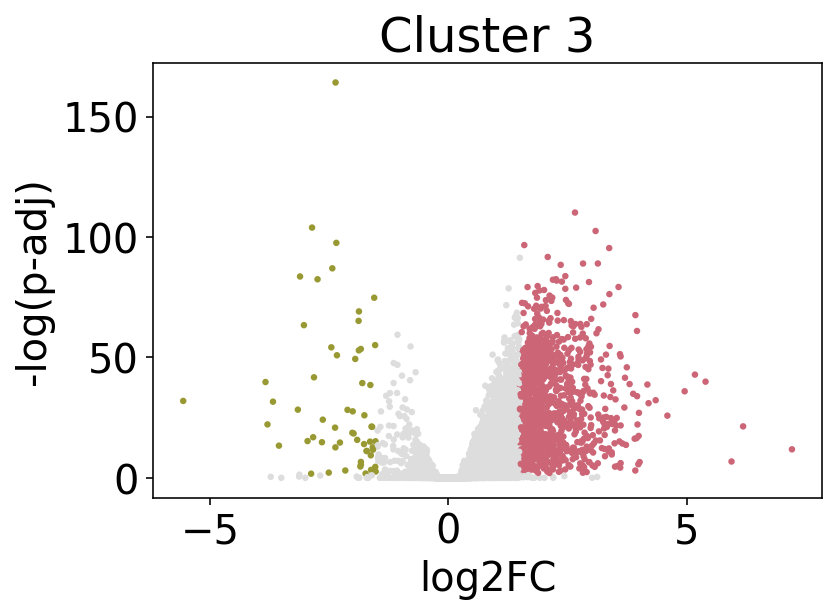

In [26]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 3')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster3.png', dpi = 400)

Cluster 4

In [27]:
xs = df_test_tt_4['log2fc']
ys = df_test_tt_4['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

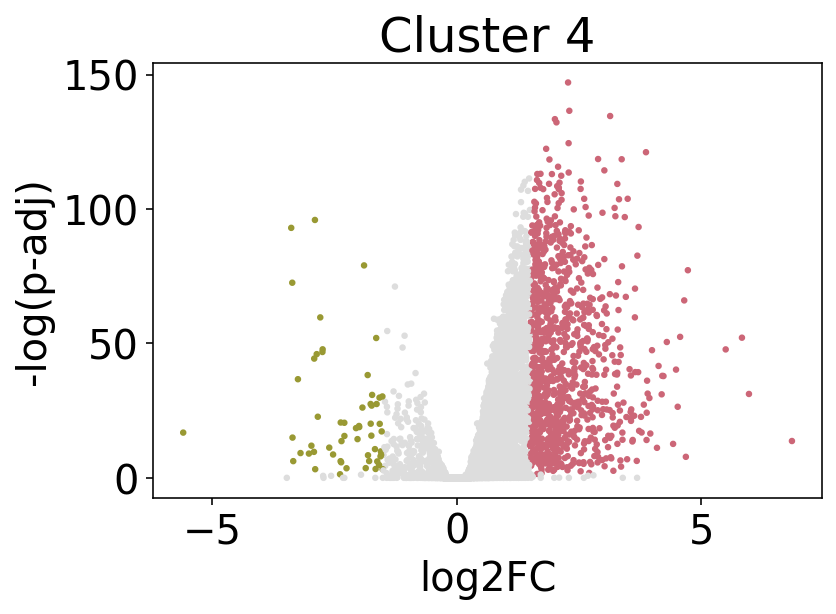

In [28]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 4')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster4.png', dpi = 400)

Cluster 5

In [29]:
xs = df_test_tt_5['log2fc']
ys = df_test_tt_5['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

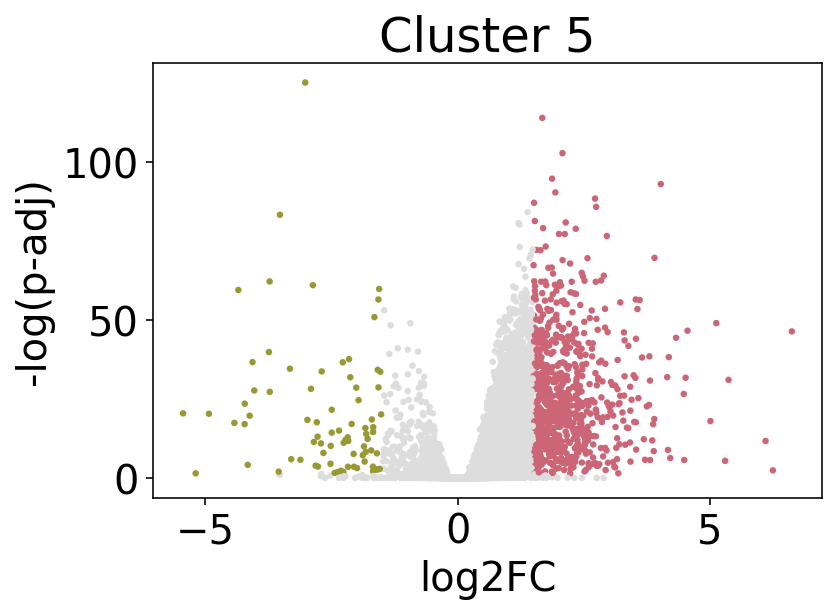

In [30]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 5')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster5.png', dpi = 400)

Cluster 6

In [31]:
xs = df_test_tt_6['log2fc']
ys = df_test_tt_6['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

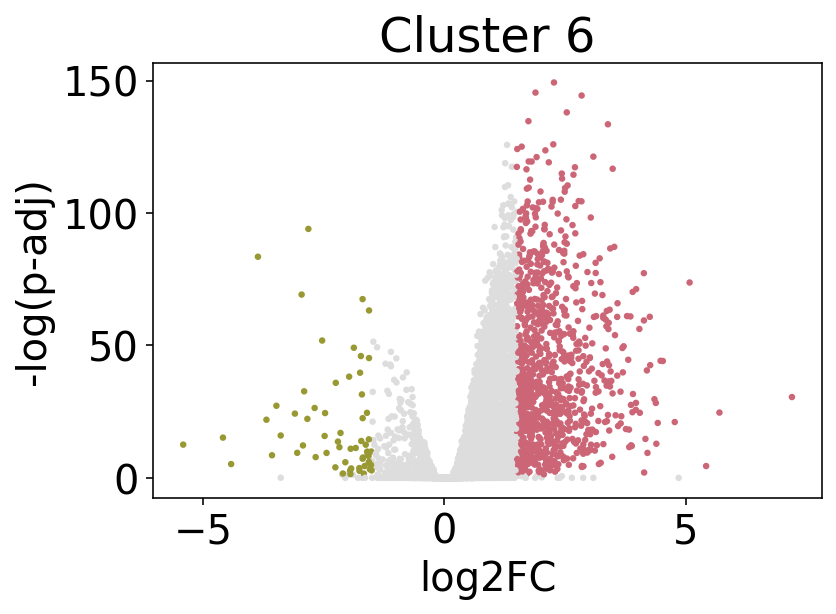

In [32]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 6')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster6.png', dpi = 400)

Cluster 7

In [33]:
xs = df_test_tt_7['log2fc']
ys = df_test_tt_7['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

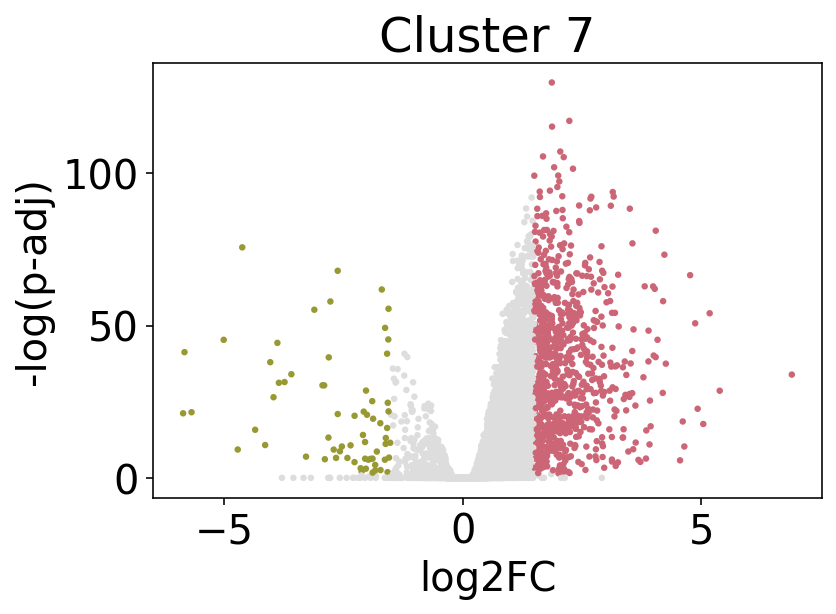

In [34]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 7')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster7.png', dpi = 400)

Cluster 8

In [35]:
xs = df_test_tt_8['log2fc']
ys = df_test_tt_8['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

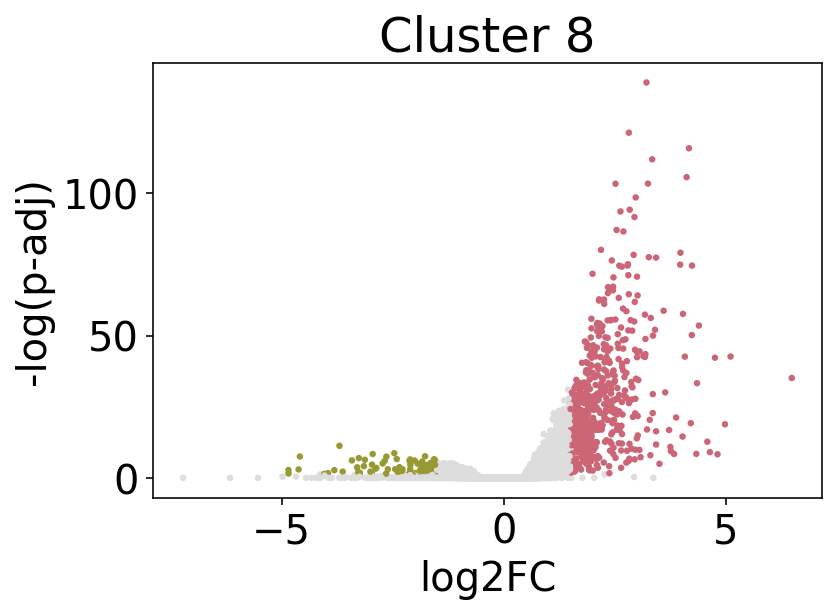

In [36]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 8')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster8.png', dpi = 400)

Cluster 9

In [37]:
xs = df_test_tt_9['log2fc']
ys = df_test_tt_9['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

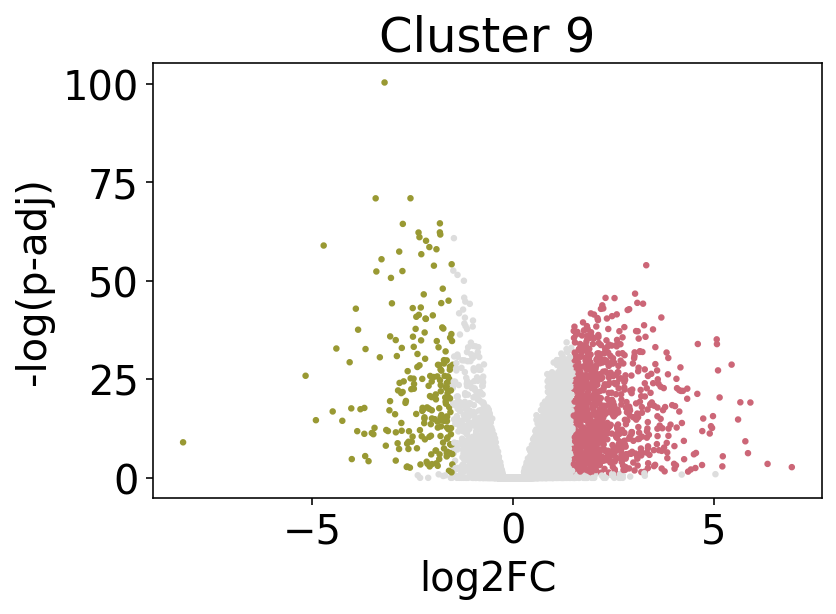

In [38]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Cluster 9')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('cluster9.png', dpi = 400)

Bulk

In [39]:
xs = df_test_tt_bulk['log2fc']
ys = df_test_tt_bulk['volcano_y']
colors = []

for x,y in zip(xs, ys):
              
        if x > 1.5 and y > 1.3:
              
            colors.append('#CC6677')
              
        elif x <-1.5 and y > 1.3:
              
            colors.append('#999933')
              
        else: 
            colors.append('#DDDDDD')

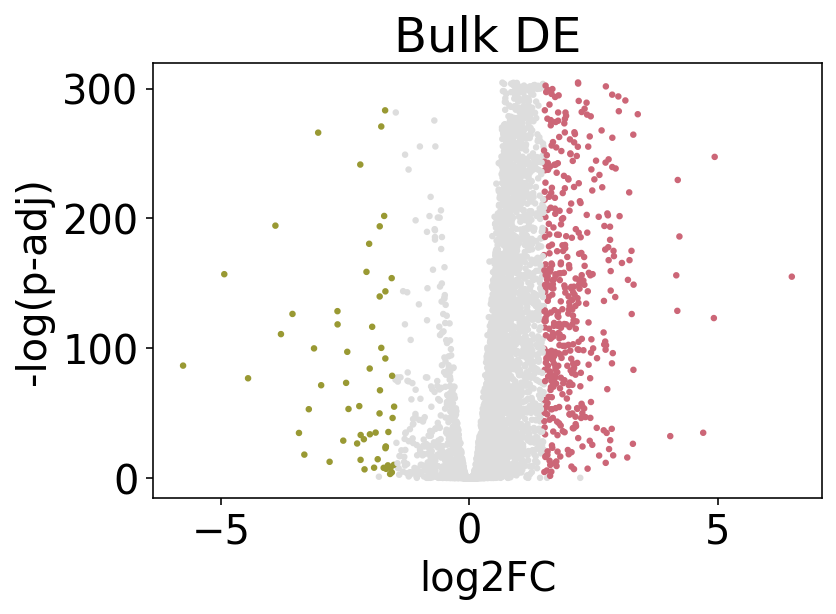

In [40]:
plt.scatter(x = xs, 
            y = ys, 
            c = colors,
            s = 5)
plt.title('Bulk DE')
plt.xlabel('log2FC')
plt.ylabel('-log(p-adj)')
plt.savefig('bulk.png', dpi = 400)

## Save df_to_plot for UpSetR

In [41]:
df_to_plot

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,pcorr
0,Su(Ste):CR42418,3.780738e-69,3.940769e-68,3.405483,0.022719,False,False,0,2.234416e-65,True,2.457858e-64
4,CG11929,1.370963e-57,9.012671e-57,1.522816,0.189578,False,False,0,8.102391e-54,True,8.912630e-53
20,bdl,1.790376e-38,6.313318e-38,1.501100,0.004348,False,False,0,1.058112e-34,True,1.163923e-33
24,l(2)k05819,4.557300e-76,6.750286e-75,2.087143,0.024437,False,False,0,2.693364e-72,True,2.962701e-71
29,ine,4.969613e-36,1.638974e-35,1.726051,0.003608,False,False,0,2.937041e-32,True,3.230746e-31
...,...,...,...,...,...,...,...,...,...,...,...
5881,upd2,4.726651e-244,2.613144e-243,2.871833,0.033199,False,False,k,2.793451e-240,True,3.072796e-239
5882,xmas,0.000000e+00,0.000000e+00,1.839427,0.056584,False,False,k,0.000000e+00,True,0.000000e+00
5884,CR46425,0.000000e+00,0.000000e+00,3.080460,0.002596,False,False,k,0.000000e+00,True,0.000000e+00
5886,Ir7g,2.639081e-139,7.885223e-139,2.191332,0.011131,False,False,k,1.559697e-135,True,1.715667e-134


In [42]:
df_to_plot.to_csv('deGenesDF.csv')

In [43]:
# activate R magic
%load_ext rpy2.ipython

In [44]:
%%R
install.packages("UpSetR",repos = "http://cran.us.r-project.org")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/UpSetR_1.4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 4194664 bytes (4.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

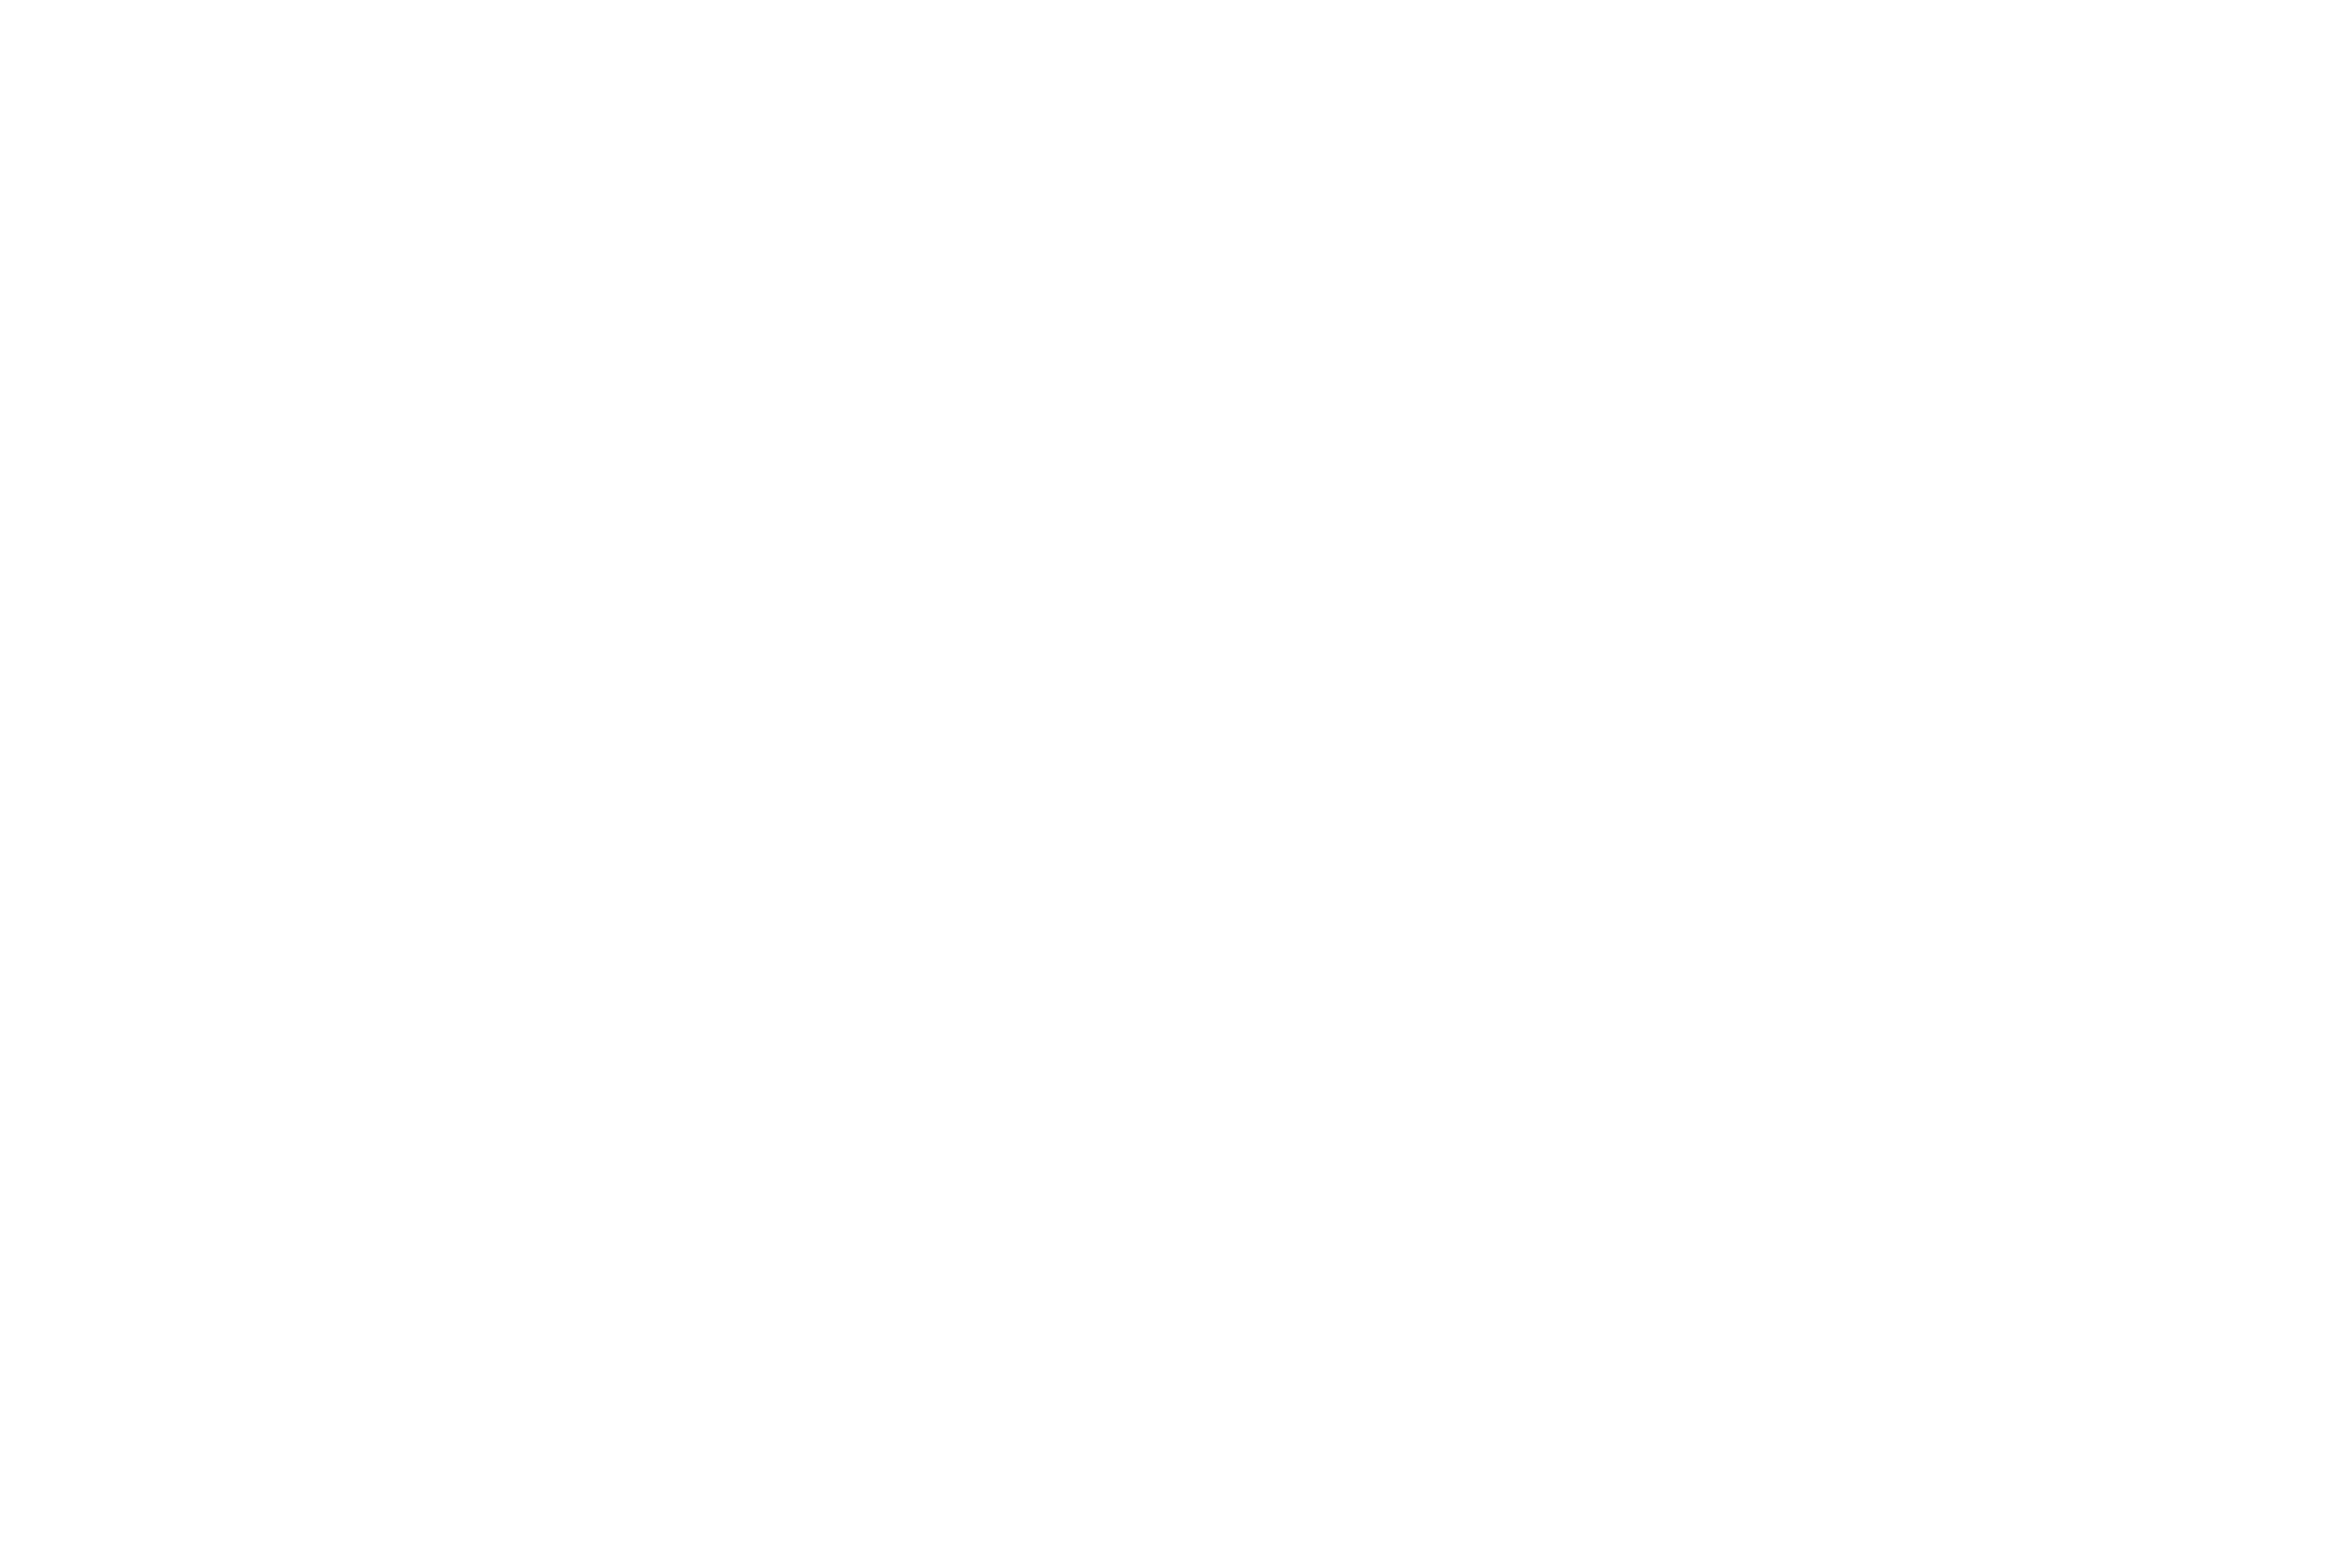

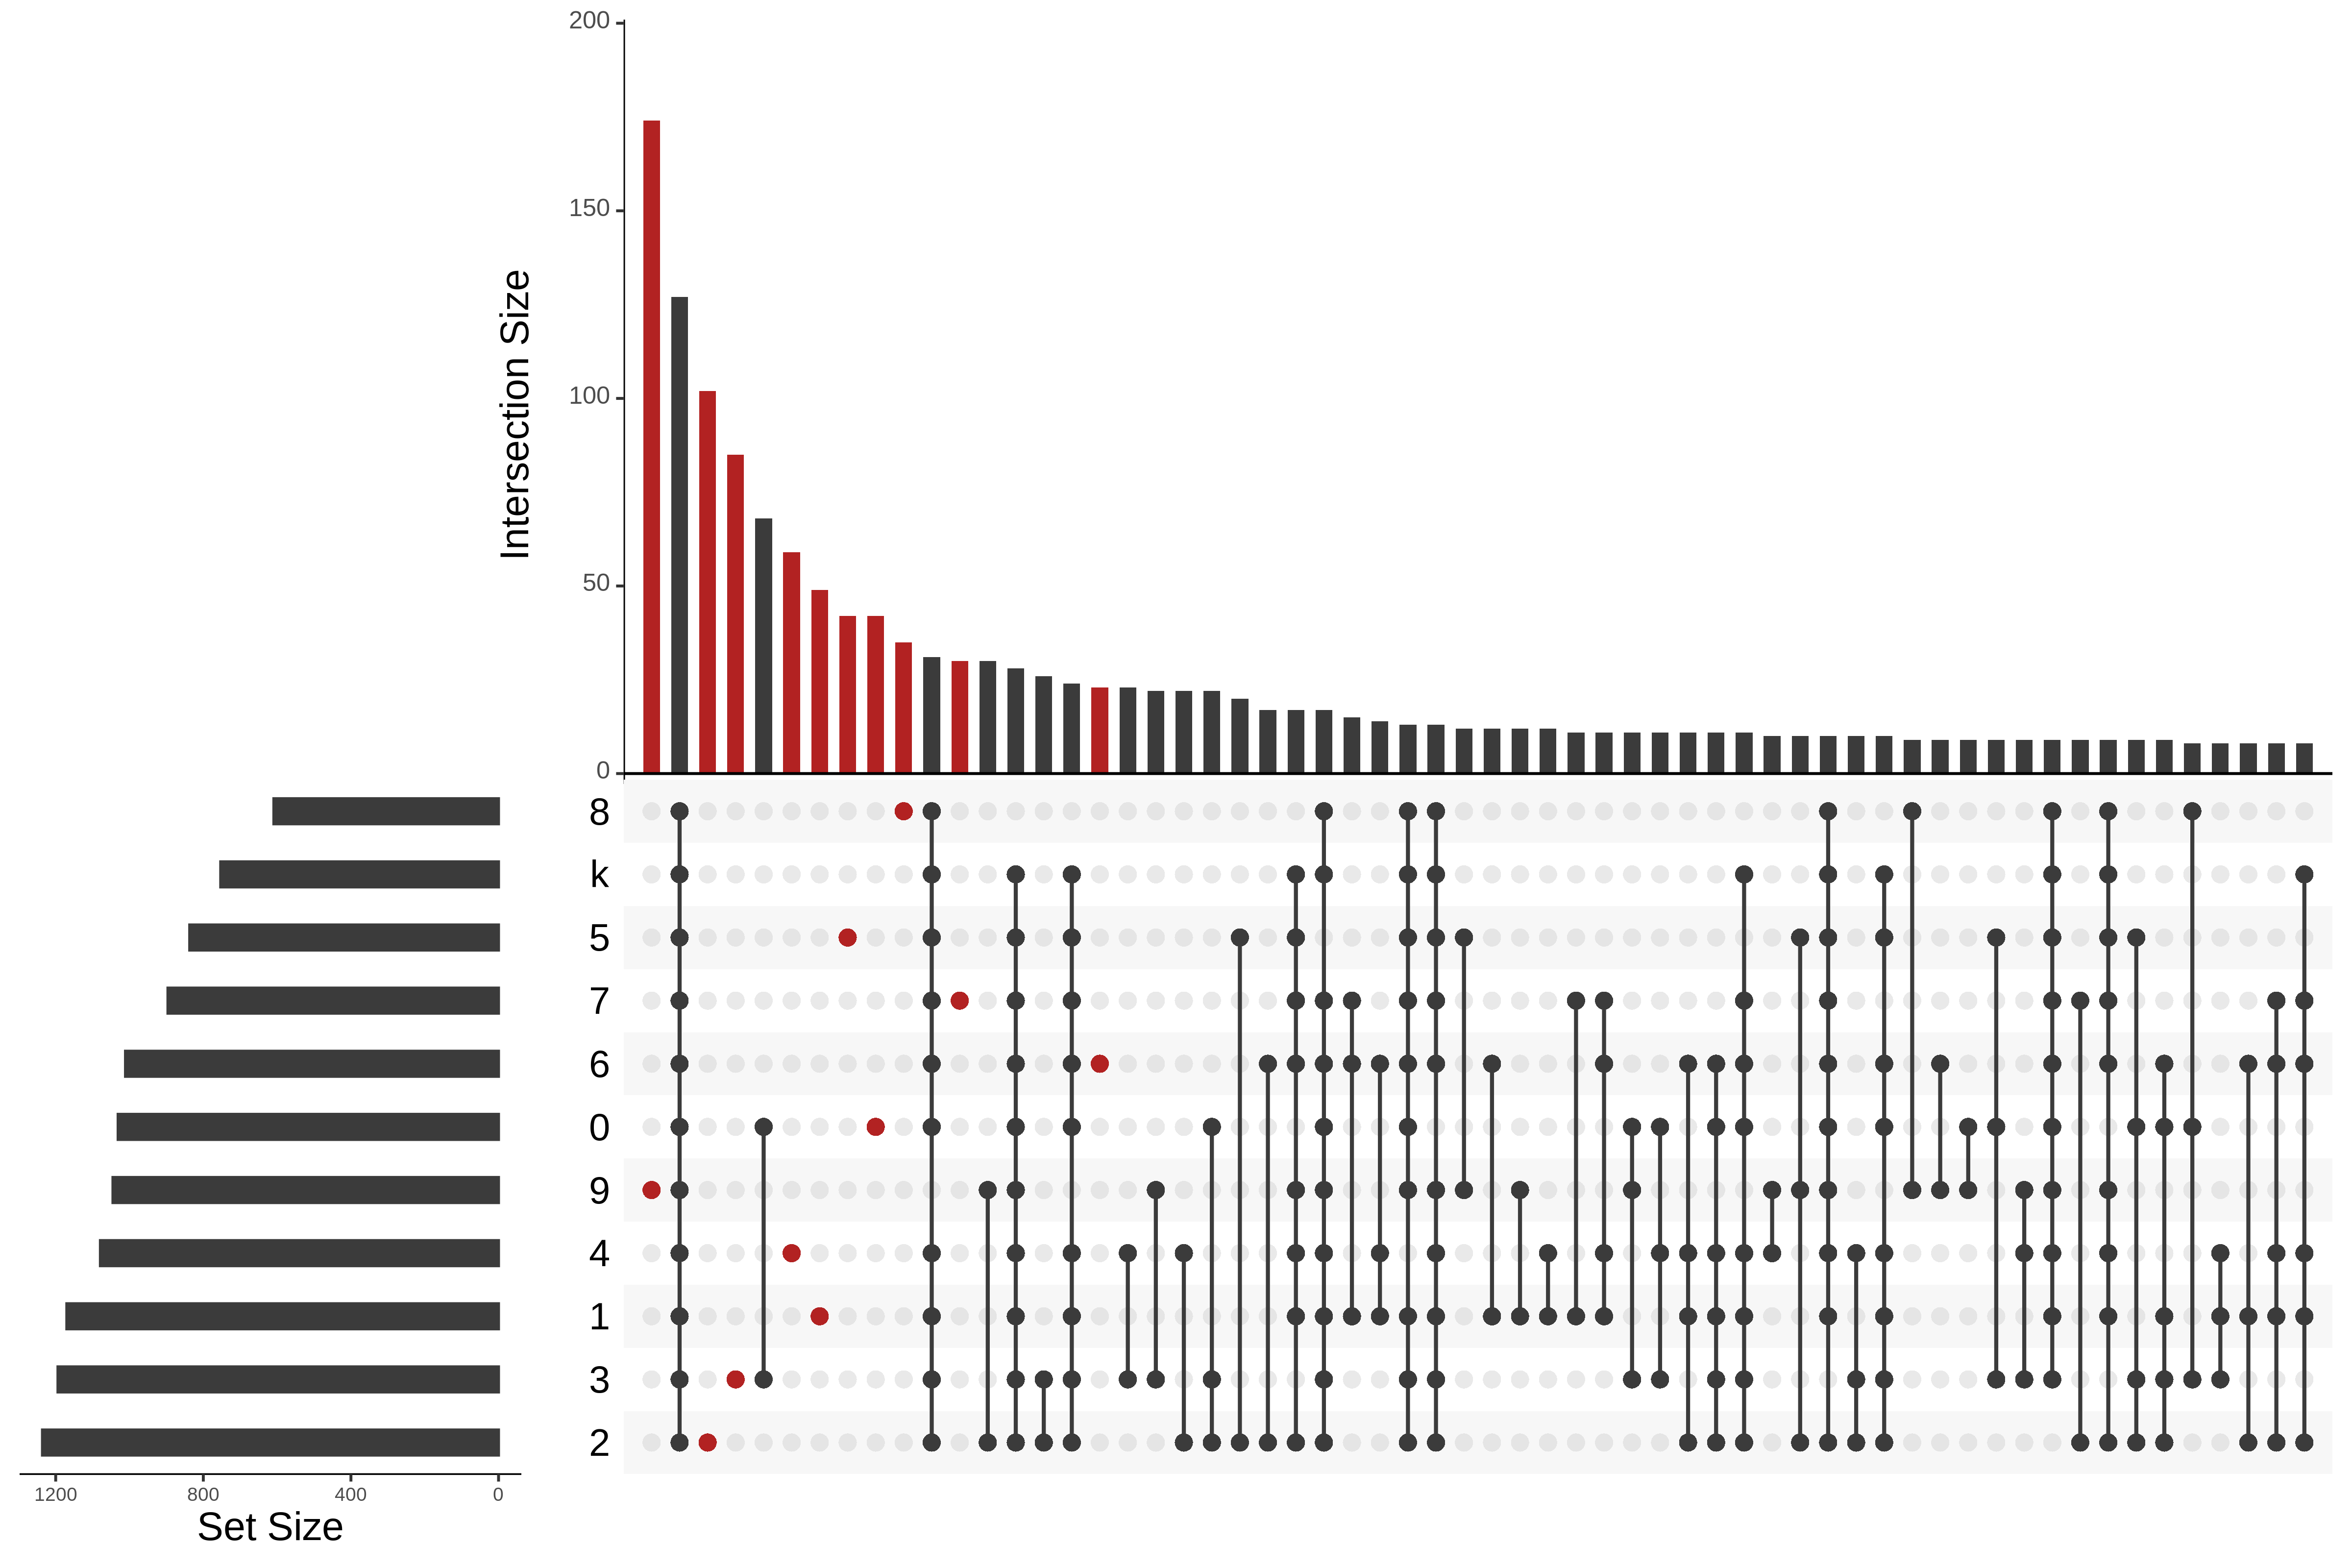

In [45]:
%%R -w 12 -h 8 --units in -r 400
library("UpSetR")
library("ggplot2")

deGenesDF <- read.csv("deGenesDF.csv")

vecsToPlot <- list()

clusters = unique(deGenesDF$cluster)

for (i in 1:length(clusters)){
  subset = subset(deGenesDF, cluster == clusters[i])
  vecsToPlot[[i]] <- unique(subset$gene)
}

names(vecsToPlot) <- clusters

upset(fromList(vecsToPlot), sets = as.character(clusters),nintersects=60, order.by = "freq",
      mainbar.y.label='Intersection Size',
      sets.x.label = 'Set Size',
      text.scale = c(1.75, 1.3, 1.75, 1, 2, 1.3),
      show.numbers = "no",
      point.size = 2.8,
      mb.ratio= c(0.5, 0.5),
      queries = list(list(query = intersects, params = list("0"), color = "firebrick",active = T),
                     list(query = intersects, params = list("1"), color = "firebrick",active = T),
                     list(query = intersects, params = list("2"), color = "firebrick",active = T),
                     list(query = intersects, params = list("3"), color = "firebrick",active = T),
                     list(query = intersects, params = list("4"), color = "firebrick",active = T),
                     list(query = intersects, params = list("5"), color = "firebrick",active = T),
                     list(query = intersects, params = list("6"), color = "firebrick",active = T),
                     list(query = intersects, params = list("7"), color = "firebrick",active = T),
                     list(query = intersects, params = list("8"), color = "firebrick",active = T),
                     list(query = intersects, params = list("9"), color = "firebrick",active = T)))

# just right click and save 

## Single Gene Plots

In [46]:
adata.X = adata.layers['norm_log_unscaled']

In [47]:
adata.obs['batch'] = adata.obs['batch'].replace({'0':'control', '1':'ctcf'})

Trying to set attribute `.obs` of view, copying.


In [48]:
gene = 'oc'

Text(0.5, 1.0, 'oc')

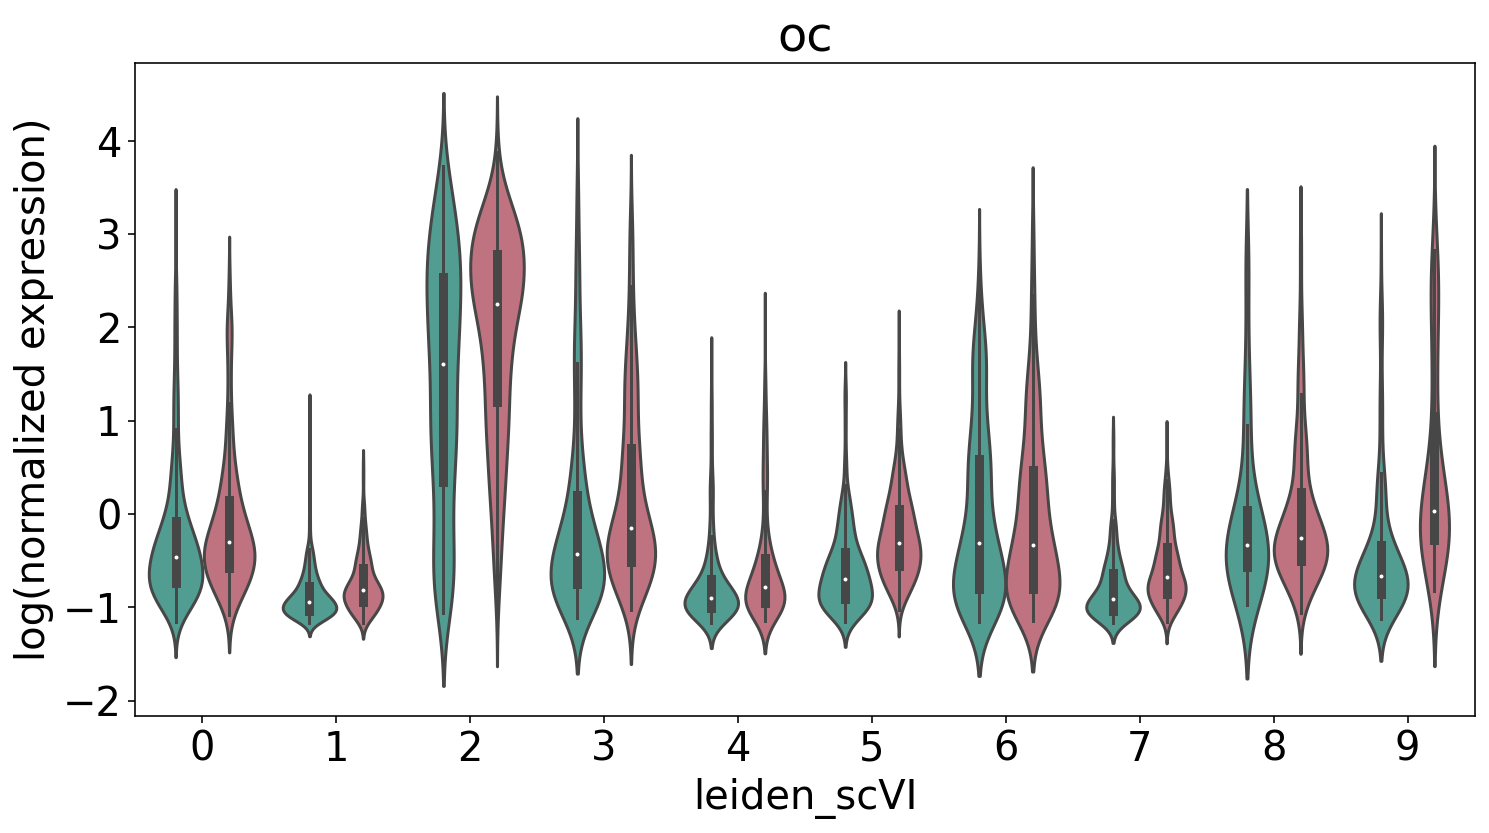

In [49]:
x = adata.obs['leiden_scVI']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (12,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
ax.get_legend().remove()
ax.set_ylabel('log(normalized expression)')
ax.set_title(gene)

Text(0.5, 1.0, 'oc')

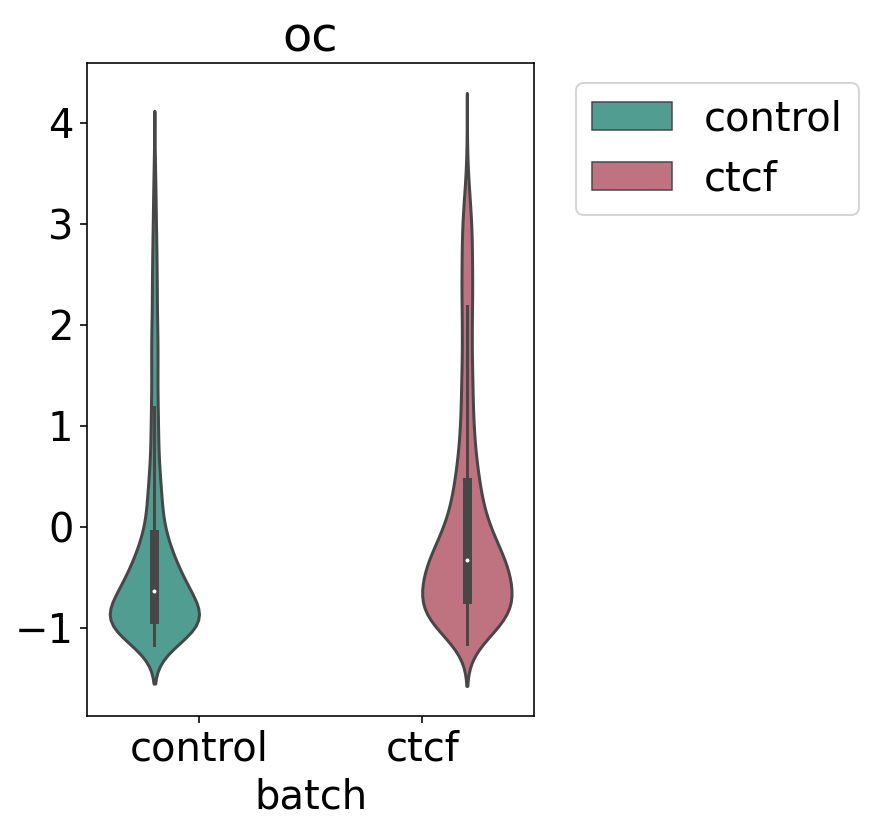

In [50]:
x = adata.obs['batch']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (4,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(gene)

In [77]:
gene = 'gd'

Text(0.5, 1.0, 'gd')

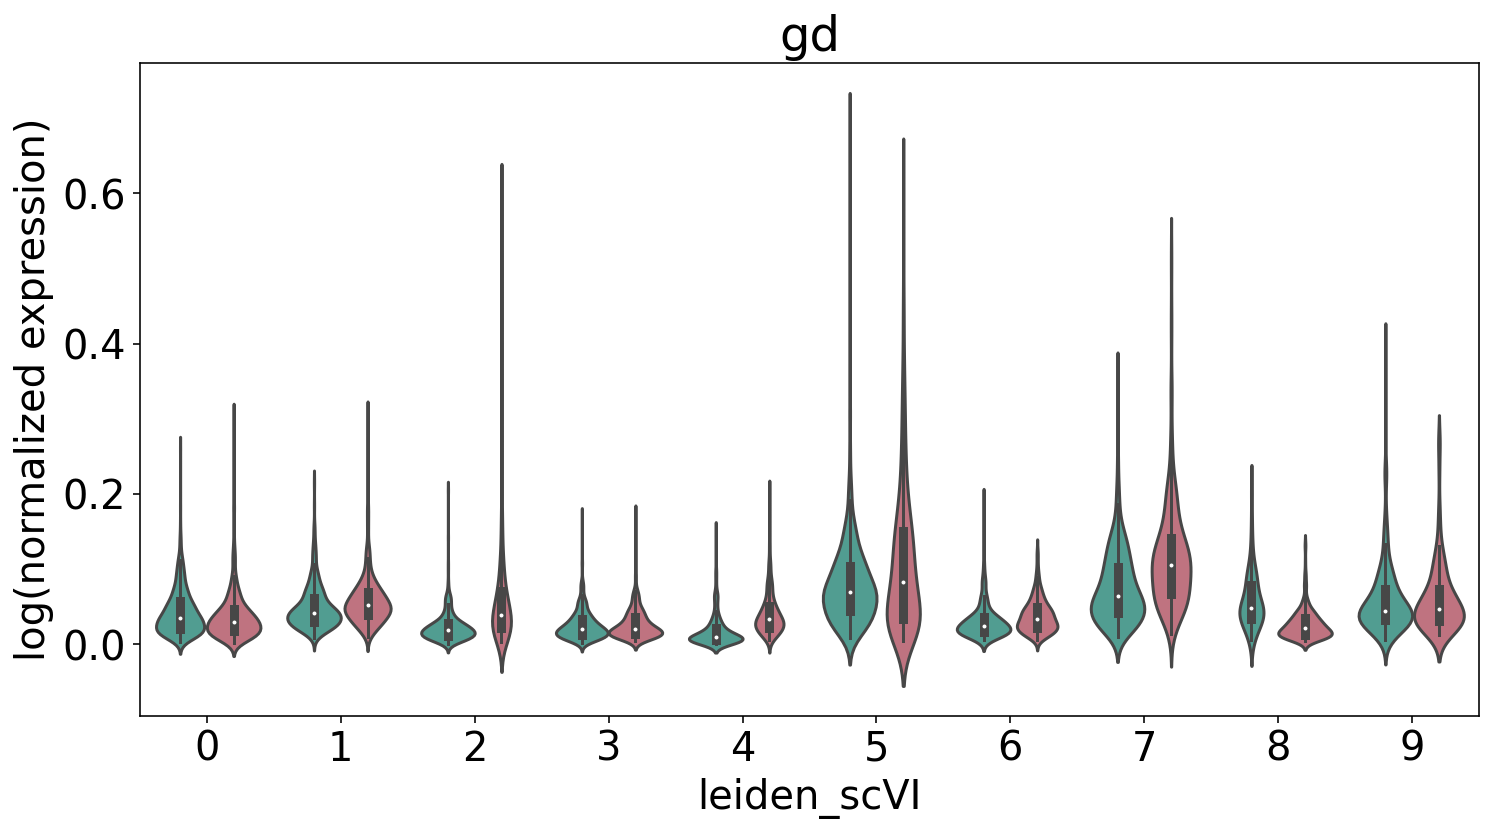

In [78]:
x = adata.obs['leiden_scVI']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (12,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
ax.get_legend().remove()
ax.set_ylabel('log(normalized expression)')
ax.set_title(gene)

Text(0.5, 1.0, 'gd')

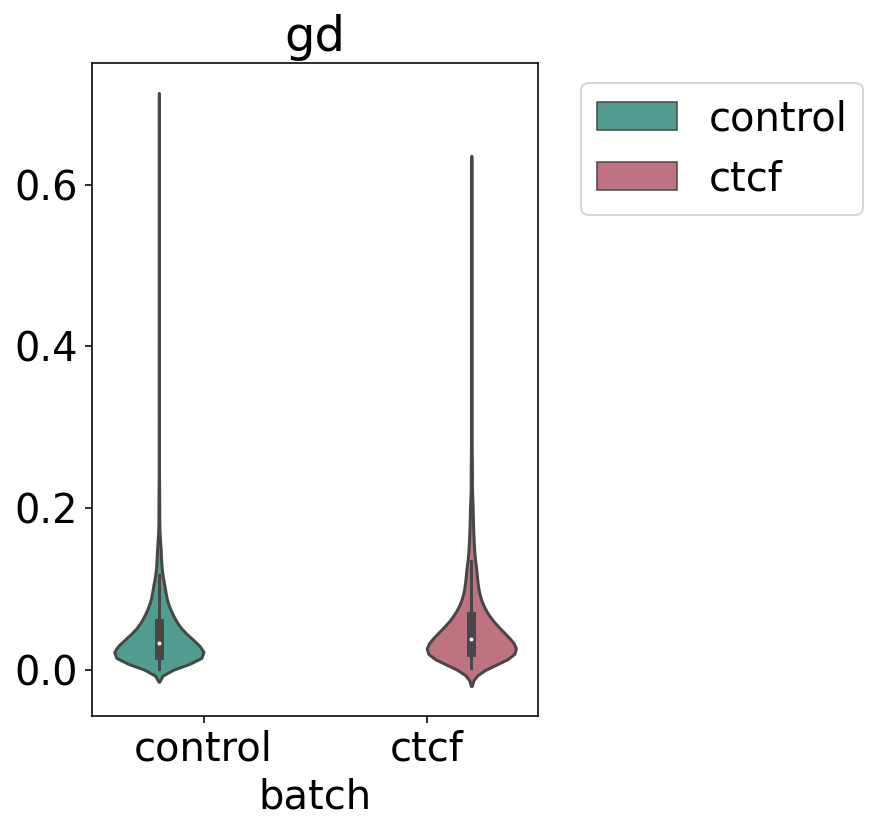

In [79]:
x = adata.obs['batch']
y = adata[:,adata.var['gene'] == gene].X.flatten()

fig, ax = plt.subplots(figsize = (4,6))

sns.violinplot(x=x, 
               y=y, 
               hue = adata.obs.batch, 
               palette = ['#44AA99', '#CC6677']
              )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(gene)

In [ ]:
frames_forpval = dfs.values()

In [ ]:
dfs.keys()

dict_keys(['df_test_tt_0', 'df_test_tt_1', 'df_test_tt_2', 'df_test_tt_3', 'df_test_tt_4', 'df_test_tt_5', 'df_test_tt_6', 'df_test_tt_7', 'df_test_tt_8', 'df_test_tt_9', 'df_test_tt_bulk'])

In [ ]:
frame_forpval = pd.concat(frames_forpval)

In [ ]:
frame_forpval.loc[frame_forpval['gene'] == gene]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance,cluster,padj,is_sig,volcano_y
5757,oc,8.955199e-03,1.050104e-02,0.659033,0.895678,False,False,0,1.000000e+00,False,-0.000000
5757,oc,1.961891e-08,2.784528e-08,0.955182,0.153426,False,False,1,1.159477e-04,False,3.935738
5757,oc,8.201248e-28,2.109198e-27,1.239593,14.714862,False,False,2,4.846938e-24,False,23.314533
5757,oc,1.654767e-02,1.984511e-02,0.627578,1.687196,False,False,3,1.000000e+00,False,-0.000000
5757,oc,5.582532e-08,8.293807e-08,1.470413,0.442864,False,False,4,3.299276e-04,False,3.481581
5757,oc,3.698311e-10,7.825642e-10,1.563908,0.369147,False,False,5,2.185702e-06,True,5.660409
5757,oc,4.129424e-02,4.760074e-02,0.619846,2.068126,False,False,6,1.000000e+00,False,-0.000000
5757,oc,4.488580e-04,6.105295e-04,0.803800,0.255942,False,False,7,1.000000e+00,False,-0.000000
5757,oc,1.429656e-01,1.904275e-01,0.515119,0.903741,False,False,8,1.000000e+00,False,-0.000000
5757,oc,4.867482e-05,7.578193e-05,2.478549,1.707295,False,False,9,2.876682e-01,False,0.541108


## Mean Normalized Expression of DE and nonDE genes

In [53]:
appearances = pd.DataFrame(df_to_plot['gene'].value_counts())

In [54]:
appearances

,gene
CG11456,11
Unc-76,11
RhoGEF64C,11
CG42749,11
sens,11
...,...
Mink,1
CG14118,1
up,1
Eip74EF,1


In [55]:
single = list(appearances[appearances['gene'] == 1].index)

In [56]:
multi = list(appearances[appearances['gene'] != 1].index)

In [57]:
notDE = adata[:,~adata.var.gene.isin(single)]
notDE = notDE[:,~notDE.var.gene.isin(multi)]

In [60]:
# make sure numbers add up 
print(len(single))
print(len(multi))
print(len(notDE.var.gene))
print(len(adata.X.mean(axis=0)))

645
1942
3323
5910


In [61]:
single_adata = adata[:,adata.var.gene.isin(single)]
multi_adata = adata[:, adata.var.gene.isin(multi)]

In [75]:
single_adata.X = single_adata.layers['X_scvi_norm']
multi_adata.X = multi_adata.layers['X_scvi_norm']
notDE.X = notDE.layers['X_scvi_norm']

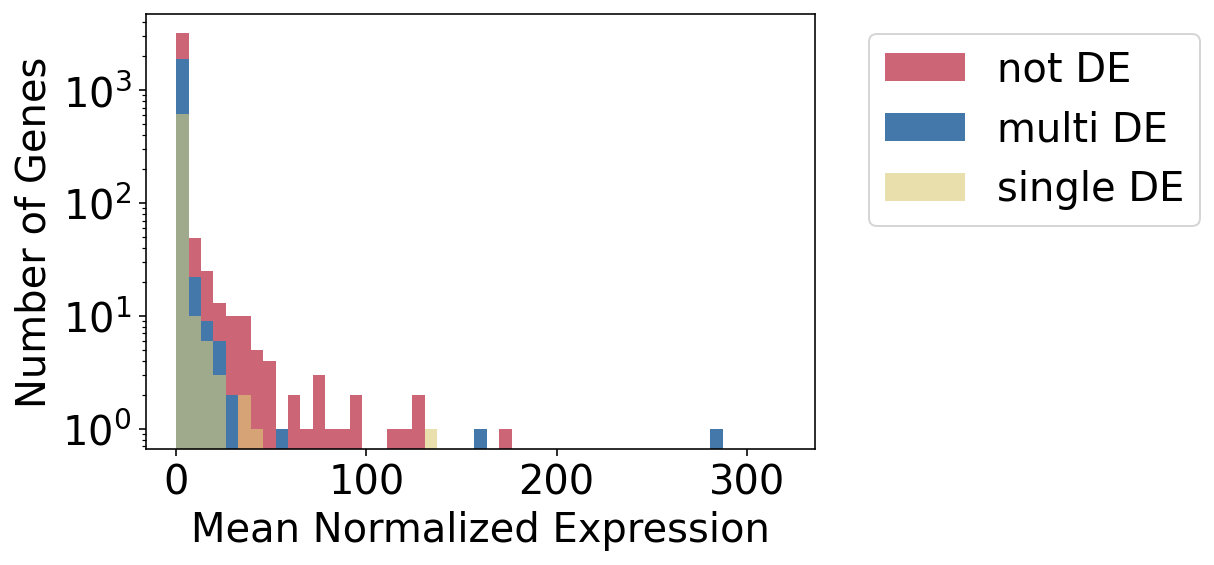

In [76]:
bins = np.linspace(0,320, 50)

fig, ax = plt.subplots()

plt.hist(notDE.X.mean(axis=0), bins = bins, color = '#CC6677', alpha = 1, label = 'not DE')
plt.hist(multi_adata.X.mean(axis=0), bins = bins, color = '#4477AA', alpha = 1, label = 'multi DE')
plt.hist(single_adata.X.mean(axis=0), bins = bins, color = '#DDCC77', alpha = 0.6, label = 'single DE')

ax.set_xlabel('Mean Normalized Expression')
ax.set_ylabel('Number of Genes')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc = "upper left")
plt.yscale('log')

## Acknowledgements

Thank you to Tara Chari for help with the UpSet plot, that code is from her [notebook](https://github.com/pachterlab/CWGFLHGCCHAP_2021/blob/691ab735fa03b834a05185faea4f36e0dfd461e5/notebooks/CellAtlasAnalysis/deSeq2Analysis_StarvationResponse.ipynb) accompanying the [preprint](https://www.biorxiv.org/content/10.1101/2021.01.22.427844v2), *Whole Animal Multiplexed Single-Cell RNA-Seq Reveals Transcriptional Shifts Across Clytia Medusae Cell Types* 